# con1 modifications

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sys
sys.path.insert(1, 'libraries')
import rc
import sections as sect
import materials as mat
import utils

In [2]:
def alpha_plot(initial,alphat,alphac,pseto='',crkso='',extra=''):
    if alphat==0: at='= 0'
    elif alphat==-1: at='-1'
    elif alphat==1: at='1'
    elif alphat>0: at='> 0'
    else: at='< 0'
    if alphac==0: ac='= 0'
    elif alphac==-1: ac='-1'
    elif alphac==1: ac='1'
    elif alphac>0: ac='> 0'
    else: ac='< 0'
    title=initial+'alphac '+ac+', alphat '+at
    if pseto!='': title=title+', pseto = '+str(pseto)
    if crkso!='': title=title+', crkso = '+str(crkso)
    if extra!='': title=title+extra
    return title

def strainHist(strain,title='Strain history',xlim=(0,None),ylim=(None,None),xlabel='Step',ylabel='Strain'):
    fig,ax = utils.plotBase()
    ax.plot(np.arange(len(strain)),strain)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()

In [3]:
class stmdl2:
    # this is con1 ADAPTIC model
    def __init__(self,ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,alphac,alphat,pseto=0,crkso=0):#pseto,crkso,
        # This subroutine calculates the stress at a monitoring point for
        # material MODEL(2).

        # Establish the stress depending on the sign of the applied
        # strain relative to the initial plastic set and crack strain
        self.ec0=ec0 # Secant compressive stiffness
        self.muec1=muec1 # Compressive softening stiffness
        self.strnc1=strnc1 # strain at residual compressive strength 
        self.stresc1=stresc1 # residual compressive strength 
        self.et0=et0 # Tensile stiffness
        self.muet1=muet1 # Tensile softening stiffness
        self.strnt1=strnt1 # strain at peak tensile strength ?
        self.pseto=pseto # plastic strain in compression at the start of the step, 
                         # represents the intersection of the unloading branch with the strain axis
        self.crkso=crkso # plastic strain in tension at the start of the step
        self.pset=pseto
        self.crks=crkso
        self.alphac=alphac
        self.alphat=alphat
        
    @classmethod # alternative constructor
    def from_ADAPTIC(cls, ec1,fc1,ec2,fc2,et1,ft,et2,alphac,alphat):
        strnc1=-fc1/ec1+(fc1-fc2)/ec2
        strnt1=ft/et1-ft/et2
        return cls(ec0=ec1,muec1=ec2,strnc1=strnc1,stresc1=-fc2,et0=et1,muet1=et2,strnt1=strnt1,alphac=alphac,alphat=alphat)
    
    def y_E1(self,x,E1,E0,x0,x1,y0,printing=True): 
        a=(E0-E1)/2/(x0-x1)
        b=E0-2*a*x0
        c=y0-a*x0**2-b*x0
        if printing: print('y(x) = {0}x**2+{1}x+{2}'.format(a,b,c))
        return (x-x0)**2*(E0-E1)/(2*(x0-x1))+E0*(x-x0)+y0

    def y_S(self,x,S,E0,x0,x1,y0,printing=True): 
        a=2*(E0-S)/2/(x0-x1)
        b=E0-2*a*x0
        c=y0-a*x0**2-b*x0
        if printing: print('y(x) = {0}x**2+{1}x+{2}'.format(a,b,c))
        return (x-x0)**2*(E0-S)/(x0-x1)+E0*(x-x0)+y0

    def y_prime_E1(self,x,E1,E0,x0,x1,y0,printing=True): 
        a=(x*(E0-E1)+x0*E1-x1*E0)/(x0-x1)
        b=(x**2*(E1-E0)-x0**2*(E0+E1)+2*x0*x1*E0)/(2*(x0-x1))+y0
        if printing: print('y\'(x) = {0}x+{1}'.format(a,b))
        return (a,b)

    def y_prime_S(self,x,S,E0,x0,x1,y0,printing=True): 
        a=(x*2*(E0-S)+x0*(2*S-E0)-x1*E0)/(x0-x1)
        b=(S*x**2-S*x0**2-x**2*E0+x0*x1*E0)/(x0-x1)+y0
        if printing: print('y\'(x) = {0}x+{1}'.format(a,b))
        return (a,b)
    
    def secant(self,S,x0,y0,printing=True): 
        a=S
        b=y0-a*x0
        if printing: print('secant: y(x) = {0}x+{1}'.format(a,b))
        return (a,b)

    def stress(self,strn,printing=False,retn='stress'):
        self.strn=strn
        
        ec0=self.ec0 # Secant compressive stiffness
        muec1=self.muec1 # Compressive softening stiffness
        strnc1=self.strnc1 # strain at residual compressive strength 
        stresc1=self.stresc1 # residual compressive strength 
        et0=self.et0 # Tensile stiffness
        muet1=self.muet1 # Tensile softening stiffness
        strnt1=self.strnt1 # strain at peak tensile strength ?
        pseto=self.pset # plastic strain in compression 
        crkso=self.crks # plastic strain in tension 
        alphac=self.alphac
        alphat=self.alphat
        
        # Establish the stress depending on the sign of the applied
        # strain relative to the initial plastic set and crack strain
        
        if(strn==pseto):
            stres=0.0
            pset=pseto
            crks=crkso
            etan=0

        if(strn<=pseto):     # Compressive strain increment

            # NOTE: alphac is the relative difference between the initial
            #       compressive tangent modulus and the secant modulus

            ec0t=(1+np.abs(alphac))*ec0
            if(alphac!=0): strnc0=(stresc1-muec1*strnc1)/(ec0-muec1)

            # Obtain the stress assuming elastic conditions, and determine
            # the force from the limiting curve

            strese=ec0t*(strn-pseto)

            if(alphac!=0 and strn>strnc0):
                stresl=strn*(ec0t+(ec0-ec0t)*strn/strnc0)
                etan=ec0t+2*(ec0-ec0t)*strn/strnc0
               
            elif(strn>strnc1):
                dstrn1=strn-strnc1

                # linear softening branch
                stresl=stresc1+muec1*dstrn1
                etan=muec1

                if(alphac<0):
                    # overaly with cubic function
                    dstrn0=strnc0-strnc1
                    dstrn1=dstrn1/dstrn0
                    stresl=stresl+2*alphac*muec1*dstrn0*dstrn1*(dstrn1-1)*(dstrn1-0.5)
                    etan=etan+alphac*muec1*(1-6*dstrn1*(1-dstrn1))

            else:
                # residual compressive strength
                stresl=stresc1
                etan=0.0

            # Establish the stress and the plastic set

            if(strese>stresl):
                stres=strese
                pset=pseto
                etan=ec0t

            else:
                stres=stresl
                pset=strn-stresl/ec0t

            crks=crkso

        elif(et0==0.0 or strn>=pseto+strnt1 or crkso>=strnt1):   # No tensile resistance
            stres=0.0
            pset=pseto
            crks=strnt1
            etan=0

        else:                                         # Tensile strain increment
            # NOTE: The tensile response is modified so that unloading points
            #       towards the origin of compressive loading response (i.e.
            #       plastic compressive strain), and the cracking strain is
            #       now defined as the maximum strain relative to the origin
            #       (rather than the unloading strain)

            pset=pseto

            strnt0=-muet1*strnt1/(et0-muet1)

            # Obatin relevant tensile strain to establish current stress on
            # loading/softening envelope

            dstrn=strn-pseto
            onEnv=True

            if(dstrn<=crkso): # unloading curve
                dstrn=crkso
                onEnv=False      # Use secant stiffness

            # Obtain relevant stress and tangent modulus on envelope

            if(dstrn<=strnt0):   # loading envelope
                if(alphat<=0):
                    # linear envelope: simple linear case, no need for further checks
                    stres=et0*dstrn # before et0*(strn-pseto)
                    stres=et0*(strn-pseto)
                    etan=et0
                    crks=crkso

                else:
                    # quadratic envelope
                    et0t=(1+alphat)*et0
                    stres=dstrn*(et0t+(et0-et0t)*dstrn/strnt0)
                    if(onEnv): etan=et0t+2*(et0-et0t)*dstrn/strnt0

            else:                     # softening envelope
                
                dstrn1=dstrn-strnt1

                # linear softening branch
                stres=muet1*dstrn1
                if(onEnv): etan=muet1

                if(alphat!=0):

                    dstrn0=strnt0-strnt1
                    dstrn1=dstrn1/dstrn0

                    if(alphat>0):
                        # overlay linear with cubic function
                        stres=stres-2*alphat*muet1*dstrn0*dstrn1*(dstrn1-1)*(dstrn1-0.5)
                        if(onEnv): etan=etan-alphat*muet1*(1-6*dstrn1*(1-dstrn1))
                    else:
                        # overlay linear with quadratic function
                        stres=stres-alphat*muet1*dstrn0*dstrn1*(dstrn1-1)
                        if(onEnv): etan=etan-alphat*muet1*(2*dstrn1-1)

            crks=dstrn

            # Determine tangent modulus as secant unloading stiffness to
            # compression origin if stress state is not on envelope

            if(not onEnv):

                etan=stres/dstrn # because dstrn=crkso
                stres=etan*(strn-pseto)

        self.strn=strn
        self.stres=stres
        self.etan=etan
        self.crks=crks
        self.pset=pset
        
        if retn=='etan': return self.etan
        elif retn=='all': return self.stres,self.etan
        else: return self.stres

    def plot(self,strain,retn='stress',title='con1',lineType='-',legend=True,lbl='stmdl2',xlim=(None,None),ylim=(None,None),ylabel='Stress [MPa]',xlabel='Strain',pseto='',crkso=''):
        # strain=np.arange(-np.absolute(self.strnc1),np.absolute(self.strnt1),0.0001)
        fig,ax = utils.plotBase()
        stress,etan=[],[]
        for j,i in enumerate(strain):
            if crkso!='': self.crks=crkso
            if pseto!='': self.pset=pseto
            self.stress(i)
            stress.append(self.stres)
            etan.append(self.etan)
#             if j>2:
#                 X=strain[-3:-1]
#                 Y=stress[-3:-1]
#                 print('step: {0}, etan: {1}, slope_intercept: {2}'.format(j,self.etan,self.slope_intercept(X,Y)[0]))
        stress=np.array(stress)
        etan=np.array(etan)
        strain=strain.reshape(len(strain),1)
        stress=stress.reshape(len(stress),1)
        etan=etan.reshape(len(etan),1)
        self.df=pd.DataFrame(np.hstack((stress,strain,etan)),columns=['stress','strain','etan'])
        if 'etan' in retn:
            if retn=='etan' or retn=='etan1':ax.plot(self.df['strain'],self.df['etan'],lineType, linewidth=2, markersize=5,label=lbl)
            if retn=='etan' or retn=='etan2':
                slope=self.slope_intercept(strain,stress)
                ax.plot(strain[:-1],slope,lineType, linewidth=2, markersize=5,label='slope')
        else: ax.plot(self.df['strain'],self.df['stress'],lineType, linewidth=2, markersize=5,label=lbl)
        if legend: ax.legend()
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        plt.show()

    def slope_intercept(self,X,Y):
        slope=[]
        for i in range(0,len(X)-1):
            if (X[i+1] - X[i])==0: 
                print('ERROR: slope_intercept({},{})'.format([X[i+1],X[i]],[Y[i+1],Y[i]]))
                slope.append(math.nan)
            else: slope.append((Y[i+1] - Y[i]) / (X[i+1] - X[i]) )
        return slope

plastic =  ('C20', 'con1', 18200, 20, -10.0, 1.0, 30300, 0.1, -100)


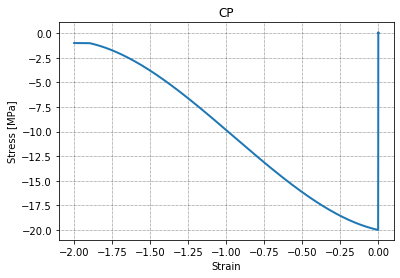

,ID,$$h[mm]$$,$$f_{c1}[MPa]$$,$$f_{c2}[MPa]$$,$$f_{t}[MPa]$$,$$E_{c0}[MPa]$$,$$E_{c1}[MPa]$$,$$E_{c2}[MPa]$$,$$E_{t1}[MPa]$$,$$E_{t2}[MPa]$$,$$G_{f}[N/mm]$$,$$G_{c}[N/mm]$$,$$e_{c1}$$,$$e_{c2}$$,$$e_{t1}$$,$$e_{t2}$$,$$alpha_{c}$$,$$alpha_{t}$$
C20,C20,250,20,1.0,0.1,30300,18200,-10.0,30300,-100,0.133,33.2,0.0011,1.9011,3e-06,0.001,-0.66,0.67


In [14]:
# Plastic
strain=np.arange(-2,.0015,0.00001)
concr=mat.con1('C20', 20, 250, epsilon_t2 = 0.001, fc2_factor = 0.05,ft_factor = 0.1/2.8, characteristic = True,Ec2=-1E+1, Et2='',plotting=False)
print('plastic = ',concr.adaptic_print())
Ec1, fc1, Ec2, fc2, Et1, ft, Et2=concr.adaptic_print()[2:]

alphac,alphat=-0.66, 0.67
Ec1, fc1, Ec2, fc2, Et1, ft, Et2,alphac,alphat=18200, 20, -1.00E+01, 1.0, 30300, 0.1, -1.00E+02, alphac,alphat
con1=stmdl2.from_ADAPTIC(Ec1, fc1, Ec2, fc2, Et1, ft, Et2,alphac,alphat)
con1.plot(strain=strain,title='CP',retn='stress',legend=False,pseto=0,crkso=0)

concr.data_frame(alpha=[alphac,alphat])

Real concrete =  ('C50', 'con1', 23200, 50, -10400, 2.5, 38600, 4.5, -5100)


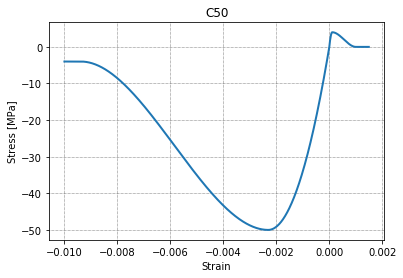

,ID,$$h[mm]$$,$$f_{c1}[MPa]$$,$$f_{c2}[MPa]$$,$$f_{t}[MPa]$$,$$E_{c0}[MPa]$$,$$E_{c1}[MPa]$$,$$E_{c2}[MPa]$$,$$E_{t1}[MPa]$$,$$E_{t2}[MPa]$$,$$G_{f}[N/mm]$$,$$G_{c}[N/mm]$$,$$e_{c1}$$,$$e_{c2}$$,$$e_{t1}$$,$$e_{t2}$$,$$alpha_{c}$$,$$alpha_{t}$$
C50,C50,250,50,2.5,4.5,38600,23200,-10400,38600,-5100,0.152,38.0,0.002159,0.006719,0.000117,0.001,-1,1


In [15]:
# Real concrete
strain=np.arange(-.01,.0015,0.00001)
concr=mat.con1('C50', 50, 250, epsilon_t2 = 0.001, fc2_factor = 0.05, characteristic = True,plotting=False)
print('Real concrete = ',concr.adaptic_print())
Ec1, fc1, Ec2, fc2, Et1, ft, Et2=concr.adaptic_print()[2:]

alphac,alphat=-1,1
Ec1, fc1, Ec2, fc2, Et1, ft, Et2,alphac,alphat=21700, 50, -6.50E+03, 4.0, 36300, 4.0, -4.50E+03, -1,1
con1=stmdl2.from_ADAPTIC(Ec1, fc1, Ec2, fc2, Et1, ft, Et2,alphac,alphat)
con1.plot(strain=strain,title='C50',retn='stress',legend=False,pseto=0,crkso=0)

concr.data_frame(alpha=[alphac,alphat])

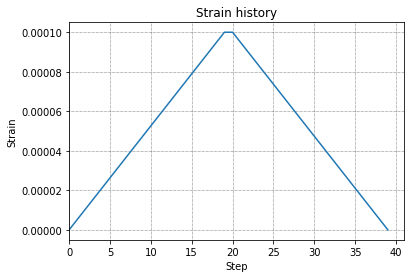

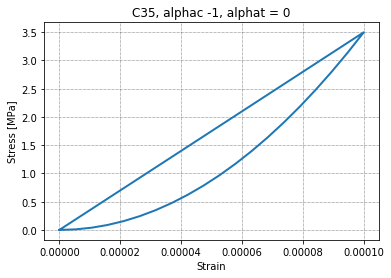

ERROR: slope_intercept([array([0.0001]), array([0.0001])],[array([3.5]), array([3.5])])


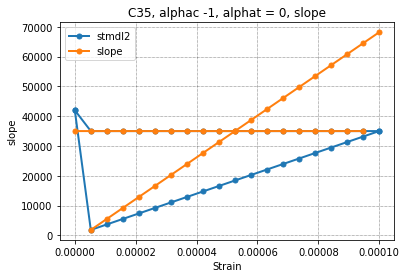

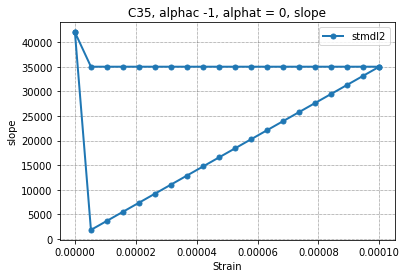

In [5]:
# Tangent line investigation
strain1=np.linspace(0,-0.0035,200)
strain2=np.linspace(strain1[-1],-0.001,200)
strain3=np.linspace(strain2[-1],-0.005,200)
strain=np.hstack((strain1,strain2,strain3))

strain1=np.linspace(0,0.0001,20)
strain2=np.linspace(strain1[-1],0,20)

strain=np.hstack((strain1,strain2))
#strain=np.linspace(0.0001,0,200)
strainHist(strain,title='Strain history')

concr = mat.con1('concrete', 35, 250, epsilon_t2 = 0.001, fc2_factor = 0.05, characteristic = True,plotting=False,)
ec0,muec1,strnc1,stresc1,et0,muet1,strnt1=concr.stmdl2_print()
alphac=-1#-concr.alpha
alphat=0

con1=stmdl2(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,alphac,alphat)
con1.plot(strain=strain,title=alpha_plot('C35, ',alphat,alphac),lineType='-',retn='stress',legend=False)
con1=stmdl2(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,alphac,alphat)
con1.plot(strain=strain,title=alpha_plot('C35, ',alphat,alphac,extra=', slope'),lineType='o-',retn='etan',legend=True,ylabel='slope')
con1=stmdl2(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,alphac,alphat)
con1.plot(strain=strain,title=alpha_plot('C35, ',alphat,alphac,extra=', slope'),lineType='o-',retn='etan1',legend=True,ylabel='slope')

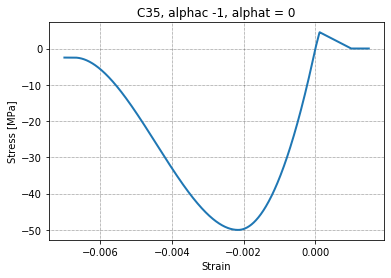

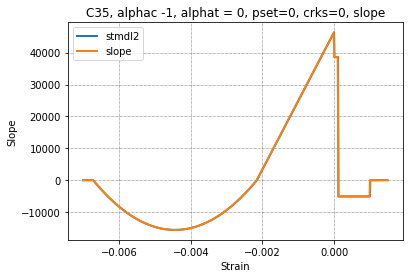

In [6]:
# Full material response

ranges=[0,.0015] # [-.0005,.00075] [-.007,.0015]
ranges=[-.007,.0015]
strain=np.arange(ranges[0],ranges[1],0.00001)
concr = mat.con1('C35', 50, 250, epsilon_t2 = 0.001, fc2_factor = 0.05, characteristic = True,plotting=False,)

# From general properties
ec0,muec1,strnc1,stresc1,et0,muet1,strnt1=concr.stmdl2_print()
alphac=-1#-concr.alpha
alphat=0
# con1=stmdl2(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,alphac,alphat)
# con1.plot(strain=strain,title=alpha_plot('C35, ',alphat,alphac),retn='stress',legend=False,pseto=0,crkso=0)
# con1=stmdl2(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,alphac,alphat)
# con1.plot(strain=strain,title=alpha_plot('C35, ',alphat,alphac,extra=', pset=0, crks=0, slope'),ylabel='Slope',retn='etan',legend=True,pseto=0,crkso=0)

# From ADAPTIC
Ec1, fc1, Ec2, fc2, Et1, ft, Et2=concr.adaptic_print()[2:]
alphac=-1#-concr.alpha
alphat=0
con1=stmdl2.from_ADAPTIC(Ec1, fc1, Ec2, fc2, Et1, ft, Et2,alphac,alphat)
con1.plot(strain=strain,title=alpha_plot('C35, ',alphat,alphac),retn='stress',legend=False,pseto=0,crkso=0)
con1=stmdl2(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,alphac,alphat)
con1.plot(strain=strain,title=alpha_plot('C35, ',alphat,alphac,extra=', pset=0, crks=0, slope'),ylabel='Slope',retn='etan',legend=True,pseto=0,crkso=0)

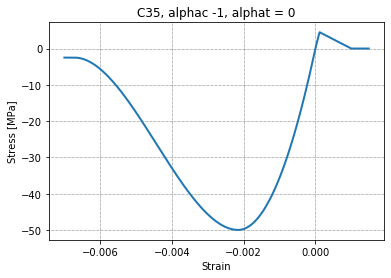

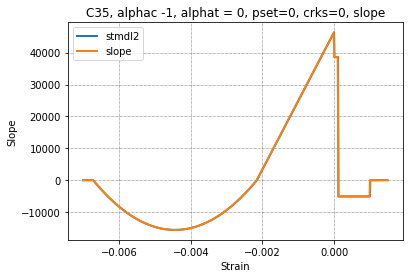

,ID,$$h[mm]$$,$$f_{c1}[MPa]$$,$$f_{c2}[MPa]$$,$$f_{t}[MPa]$$,$$E_{c0}[MPa]$$,$$E_{c1}[MPa]$$,$$E_{c2}[MPa]$$,$$E_{t1}[MPa]$$,$$E_{t2}[MPa]$$,$$G_{f}[N/mm]$$,$$G_{c}[N/mm]$$,$$e_{c1}$$,$$e_{c2}$$,$$e_{t1}$$,$$e_{t2}$$,$$alpha_{c}$$,$$alpha_{t}$$
C35,C35,250,50,2.5,4.5,38600,23200,-10400,38600,-5100,0.152,38.0,0.002159,0.006719,0.000117,0.001,-0.66,0.66


In [16]:
# Full material response
concr = mat.con1('C35', 50, 250, epsilon_t2 = 0.001, fc2_factor = 0.05, characteristic = True,plotting=False,)
ec0,muec1,strnc1,stresc1,et0,muet1,strnt1=concr.stmdl2_print()
alphac=-1#-concr.alpha
alphat=0

ranges=[0,.0015] # [-.0005,.00075] [-.007,.0015]
ranges=[-.007,.0015]
strain=np.arange(ranges[0],ranges[1],0.00001)

con1=stmdl2(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,alphac,alphat)
con1.plot(strain=strain,title=alpha_plot('C35, ',alphat,alphac),retn='stress',legend=False,pseto=0,crkso=0)
con1=stmdl2(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,alphac,alphat)
con1.plot(strain=strain,title=alpha_plot('C35, ',alphat,alphac,extra=', pset=0, crks=0, slope'),ylabel='Slope',retn='etan',legend=True,pseto=0,crkso=0)

concr.data_frame() #alpha=[alphac,alphat]

In [8]:
alphac=concr.alpha
alphat=-1
con1=stmdl2(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,alphac,alphat)
con1.stress(0.0001)
print('strn',con1.strn)
print('stres',con1.stres)
print('etan',con1.etan)
print('pset',con1.pset)
print('crks',con1.crks)

strn 0.0001
stres 3.8600000000000003
etan 38600
pset 0
crks 0.0001


In [9]:
print('ec0=',concr.Ec1)
print('ec0t=',concr.Ec0)
print('muec1=',concr.Ec2)
print('et0=',concr.Et1)
print('muet1=',concr.Et2)
print('strnt0=',concr.epsilon_1t)
print('strnt1=',concr.epsilon_2t)
print('strnc0=',-concr.epsilon_1c)
print('strnc1=',-concr.epsilon_2c)
print('stresc1=',-concr.fc2)
print('strest1=',-concr.ft)
print('strnt1=',concr.epsilon_1t)
print('strnt2=',concr.epsilon_2t)
print('quad=',concr.alpha)
print('etan=',concr.Ec0)

ec0= 23200
ec0t= 38600
muec1= -10400
et0= 38600
muet1= -5100
strnt0= 0.000117
strnt1= 0.001
strnc0= -0.002159
strnc1= -0.006719
stresc1= -2.5
strest1= -4.5
strnt1= 0.000117
strnt2= 0.001
quad= 0.66
etan= 38600


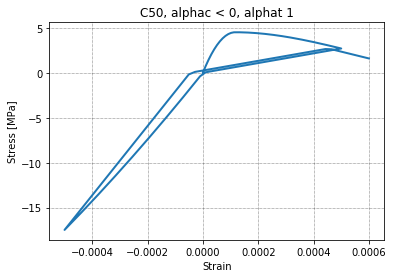

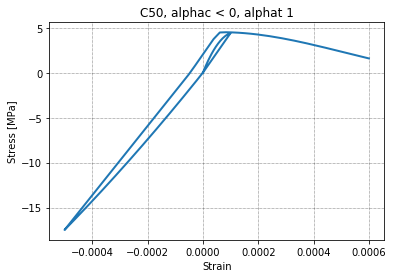

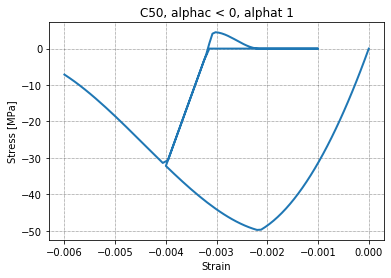

In [10]:
# Analyse strain history
concr = mat.con1('C50', 50, 250, epsilon_t2 = 0.001, fc2_factor = 0.05, characteristic = True,plotting=False,)
ec0,muec1,strnc1,stresc1,et0,muet1,strnt1=concr.stmdl2_print()
alphac=-concr.alpha
alphat=1

# 0,0.0005,-0.0005,0.0006

strain1=np.linspace(0,0.0005,50)
strain2=np.linspace(strain1[-1],-0.0005,50)
strain3=np.linspace(strain2[-1],0.0006,50)
strain=np.hstack((strain1,strain2,strain3))

con1=stmdl2(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,alphac,alphat)
con1.plot(strain=strain,title=alpha_plot('C50, ',alphat,alphac),retn='stress',legend=False)


# 0,0.0001,-0.0005,0.0006

strain1=np.linspace(0,0.0001,50)
strain2=np.linspace(strain1[-1],-0.0005,50)
strain3=np.linspace(strain2[-1],0.0006,50)
strain=np.hstack((strain1,strain2,strain3))

con1=stmdl2(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,alphac,alphat)
con1.plot(strain=strain,title=alpha_plot('C50, ',alphat,alphac),retn='stress',legend=False)

# 0,-0.004,-0.001,-0.006

strain1=np.linspace(0,-0.004,50)
strain2=np.linspace(strain1[-1],-0.001,50)
strain3=np.linspace(strain2[-1],-0.006,50)
strain=np.hstack((strain1,strain2,strain3))

con1=stmdl2(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,alphac,alphat)
con1.plot(strain=strain,title=alpha_plot('C50, ',alphat,alphac),retn='stress',legend=False)